### Package import

In [132]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn import tree, preprocessing
from sklearn import linear_model, model_selection, metrics, random_projection
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### Data Preprocessing

#### Data Loading

In [133]:
from sqlalchemy import create_engine
my_conn = create_engine("sqlite:////Users/Yi/Desktop/Wildfire/FPA_FOD_20221014.sqlite")

In [134]:
# present all the data 
r_set = my_conn.execute('''select name from sqlite_master where type = 'table' ''')
for row in r_set:
    print(row)

('spatial_ref_sys',)
('spatialite_history',)
('sqlite_sequence',)
('geometry_columns',)
('views_geometry_columns',)
('virts_geometry_columns',)
('geometry_columns_statistics',)
('views_geometry_columns_statistics',)
('virts_geometry_columns_statistics',)
('geometry_columns_field_infos',)
('views_geometry_columns_field_infos',)
('virts_geometry_columns_field_infos',)
('geometry_columns_time',)
('geometry_columns_auth',)
('views_geometry_columns_auth',)
('virts_geometry_columns_auth',)
('sql_statements_log',)
('SpatialIndex',)
('NWCG_UnitIdActive_20200123',)
('Fires',)
('idx_Fires_Shape',)
('idx_Fires_Shape_rowid',)
('idx_Fires_Shape_node',)
('idx_Fires_Shape_parent',)


In [135]:
# select related table 
df_raw = pd.read_sql_query("SELECT FIRE_YEAR, NWCG_GENERAL_CAUSE, LATITUDE, LONGITUDE, STATE, DISCOVERY_DATE, FIRE_SIZE, FIRE_SIZE_CLASS FROM 'Fires'", my_conn)

#### Data Exploratory Analysis

In [136]:
df_raw.describe()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE
count,2.303566e+06,2.303566e+06,2.303566e+06,2.303566e+06
mean,2.006167e+03,3.696623e+01,-9.635792e+01,7.816088e+01
std,8.044361e+00,6.008260e+00,1.664360e+01,2.630832e+03
min,1.992000e+03,1.793972e+01,-1.788026e+02,1.000000e-05
25%,2.000000e+03,3.301390e+01,-1.110361e+02,1.000000e-01
50%,2.006000e+03,3.572250e+01,-9.347009e+01,8.000000e-01
75%,2.013000e+03,4.089029e+01,-8.251000e+01,3.000000e+00
max,2.020000e+03,7.033060e+01,-6.525694e+01,6.627000e+05


In [137]:
df_raw.head(10)

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS
0,2005,Power generation/transmission/distribution,40.036944,-121.005833,CA,2/2/2005,0.10,A
1,2004,Natural,38.933056,-120.404444,CA,5/12/2004,0.25,A
2,2004,Debris and open burning,38.984167,-120.735556,CA,5/31/2004,0.10,A
3,2004,Natural,38.559167,-119.913333,CA,6/28/2004,0.10,A
4,2004,Natural,38.559167,-119.933056,CA,6/28/2004,0.10,A
5,2004,Natural,38.635278,-120.103611,CA,6/30/2004,0.10,A
6,2004,Natural,38.688333,-120.153333,CA,7/1/2004,0.10,A
7,2005,Debris and open burning,40.968056,-122.433889,CA,3/8/2005,0.80,B
8,2005,Debris and open burning,41.233611,-122.283333,CA,3/15/2005,1.00,B
9,2004,Natural,38.548333,-120.149167,CA,7/1/2004,0.10,A


<AxesSubplot:title={'center':'Fire Cause Frequency Plot'}>

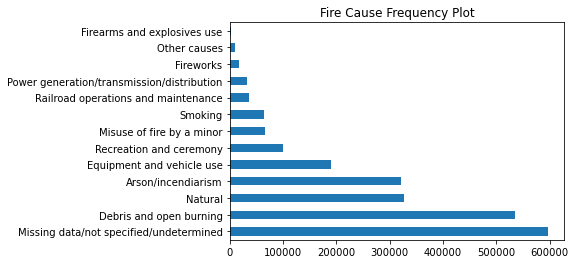

In [138]:
df_raw['NWCG_GENERAL_CAUSE'].value_counts().plot(kind='barh', title='Fire Cause Frequency Plot')

<AxesSubplot:title={'center':'Top 10 States with Most Wildfires'}>

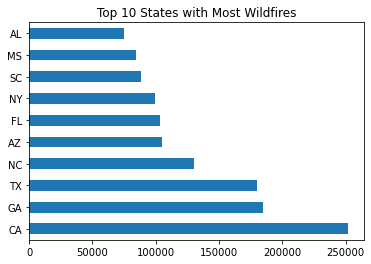

In [139]:
df_raw['STATE'].value_counts().head(10).plot(kind='barh', title='Top 10 States with Most Wildfires')

<AxesSubplot:title={'center':'Geometric Distribution of Wildfires'}, xlabel='LONGITUDE', ylabel='LATITUDE'>

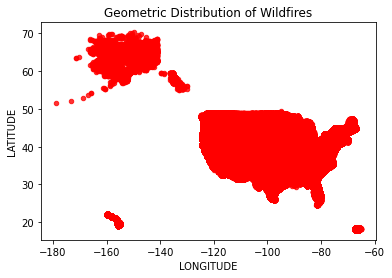

In [140]:
df_raw.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', color='red', alpha=0.8, title='Geometric Distribution of Wildfires')

#### Data Preprocessing

In [141]:
# check null value
df_raw.isnull().sum()

FIRE_YEAR             0
NWCG_GENERAL_CAUSE    0
LATITUDE              0
LONGITUDE             0
STATE                 0
DISCOVERY_DATE        0
FIRE_SIZE             0
FIRE_SIZE_CLASS       0
dtype: int64

In [142]:
# reduce number of classes (cause)
all_causes = set(df_raw['NWCG_GENERAL_CAUSE'])
for c in all_causes:
    print(c)    

# reduce the number of classes of the fire causes
CATEGORY = {}
CATEGORY[1] = ['Natural']
CATEGORY[2] = ['Power generation/transmission/distribution', 
               'Fireworks', 
               'Firearms and explosives use', 
               'Debris and open burning',
               'Smoking',
               'Railroad operations and maintenance',
               'Misuse of fire by a minor',
               'Equipment and vehicle use',
               'Recreation and ceremony']
CATEGORY[3] = ['Arson/incendiarism']
CATEGORY[4] = ['Missing data/not specified/undetermined', 'Other causes']


def set_label(cause):
    if cause in CATEGORY[1]:
        res = 1
    elif cause in CATEGORY[2]:
        res = 2
    elif cause in CATEGORY[3]:
        res = 3
    else:
        res = 4
    return res

df_raw['LABEL'] = df_raw['NWCG_GENERAL_CAUSE'].apply(lambda c: set_label(c))

Firearms and explosives use
Power generation/transmission/distribution
Fireworks
Natural
Missing data/not specified/undetermined
Debris and open burning
Smoking
Other causes
Misuse of fire by a minor
Equipment and vehicle use
Arson/incendiarism
Recreation and ceremony
Railroad operations and maintenance


<AxesSubplot:>

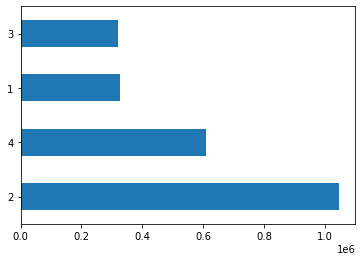

In [143]:
df_raw['LABEL'].value_counts().plot(kind='barh')

In [144]:
df = df_raw.copy()
label = LabelEncoder()

# use label encoder to encode the date information
df['STATE'] = label.fit_transform(df['STATE'])
df['FIRE_SIZE_CLASS'] = label.fit_transform(df['FIRE_SIZE_CLASS'])

# extract date information from 'DISCOVERY_DATE' 
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'])
df['DAY_OF_WEEK'] = df['DISCOVERY_DATE'].dt.day_name()
df['DAY_OF_WEEK'] = label.fit_transform(df['DAY_OF_WEEK'])
df['MONTH'] = df['DISCOVERY_DATE'].dt.month
df['DISCOVERY_DATE'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).to_julian_date()
df

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LABEL,DAY_OF_WEEK,MONTH
0,2005,Power generation/transmission/distribution,40.036944,-121.005833,4,2453403.5,0.10,0,2,6,2
1,2004,Natural,38.933056,-120.404444,4,2453137.5,0.25,0,1,6,5
2,2004,Debris and open burning,38.984167,-120.735556,4,2453156.5,0.10,0,2,1,5
3,2004,Natural,38.559167,-119.913333,4,2453184.5,0.10,0,1,1,6
4,2004,Natural,38.559167,-119.933056,4,2453184.5,0.10,0,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...
2303561,2020,Natural,39.037890,-108.959500,5,2459005.5,1.00,1,1,0,6
2303562,2020,Missing data/not specified/undetermined,37.148611,-119.503056,4,2459041.5,100.00,3,4,2,7
2303563,2020,Natural,46.151370,-114.442800,26,2459088.5,50.00,2,1,4,8
2303564,2020,Natural,46.670340,-120.114500,48,2459078.5,24892.00,6,1,1,8


In [145]:
# group the data by different state
df_by_state = {}
df_group = df.groupby(by='STATE')
for key, value in df_group:
    df_by_state[key] = value

Based on the value count of the different causes, the dataset is highly unbalanced, we need to oversample the less common classes. Here we perform a **Synthetic Minority Oversampling Technique (SMOTE)** to balance the dataset

In [147]:
# reduce sample size and split the dataset to form X and y and do resampling
reduced_df = df.sample(n=200000, random_state=10).reset_index(drop=True)
X, y = reduced_df.drop(['NWCG_GENERAL_CAUSE', 'LABEL'], axis=1), reduced_df['LABEL']

# oversample the minority classes
smote = SMOTE(random_state=10)
X, y = smote.fit_resample(X, y)

# split training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# standardize the data
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

<AxesSubplot:>

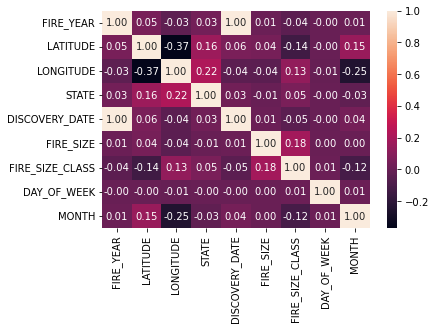

In [148]:
# variable correlation heatmap
X_train_df = pd.DataFrame(data=X_train, columns=['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'DAY_OF_WEEK', 'MONTH'])
sns.heatmap(X_train_df.corr(), annot=True, fmt=".2f")

### Machine Learning Model Training

#### Helper Functions

In [149]:
# draw the confusion matrix
def draw_confusion(model, verbose=False):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    cmn = np.round(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], 4)
    if verbose:
        print("Confusion matrix is", cmn)

    ax = plt.subplot()
    sns.heatmap(cmn, annot=True, fmt='g', ax=ax)

    ax.set_xlabel("Predicted Cause Label")
    ax.set_ylabel("True Cause Label")
    labels = ['Natural', 'Accidental', 'Deliberate', 'Other']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels[::-1])

    plt.show()

#### Random Forest

In [150]:
clf_rf = RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print("Vannila random forest classification accuracy", clf_rf.score(X_test, y_test))

Vannila random forest classification accuracy 0.7540394973070018


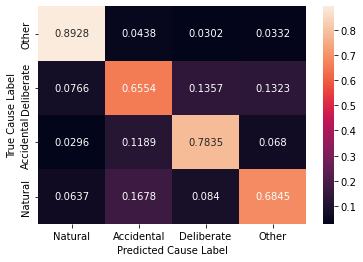

In [151]:
# visualization of each class's accuracy
draw_confusion(clf_rf)

#### Logistic Regression

In [152]:
from sklearn.linear_model import LogisticRegression
clf_logit = LogisticRegression(multi_class='ovr', class_weight='balanced', warm_start=True).fit(X_train, y_train)
print("Logistic classification accuracy", clf_logit.score(X_test, y_test))

Logistic classification accuracy 0.43255596673139635


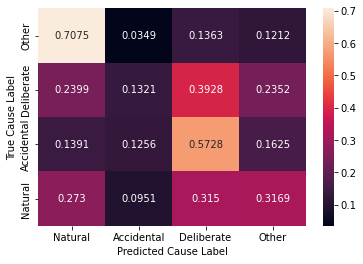

In [153]:
draw_confusion(clf_logit)

#### Gradient Boosting Tree

In [154]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gbt = GradientBoostingClassifier().fit(X_train, y_train)
print("Gradient boosting tree accuracy", clf_gbt.score(X_test, y_test))

Gradient boosting tree accuracy 0.6275235408346462


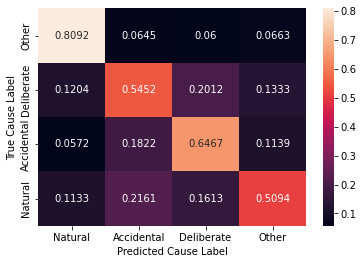

In [155]:
draw_confusion(clf_gbt)

#### Support Vector Machine

In [156]:
from sklearn import svm
clf_svm = svm.LinearSVC()
clf_svm.fit(X_train, y_train)
print("Support vector machine accuracy", clf_svm.score(X_test, y_test))

Support vector machine accuracy 0.4358901549847946


/Users/Yi/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


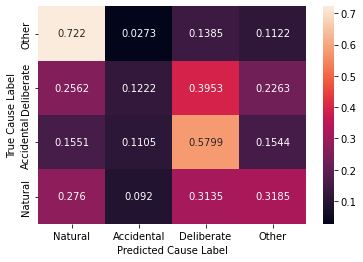

In [157]:
draw_confusion(clf_svm)

### Save Trained Models

In [161]:
# save input scaler
joblib.dump(std, 'standard_scaler.pkl')
# save machine learning models
joblib.dump(clf_rf, 'random_forest.pkl')
joblib.dump(clf_gbt, 'gbt.pkl')
joblib.dump(clf_logit, 'logistic.pkl')
joblib.dump(clf_svm, 'svm.pkl')


"""
scaler = joblib.load(scaler.pkl)
model = joblib.load(model.pkl)
X_test = scaler.transform(X_test)
model.predict(X_test)
"""


'\nscaler = joblib.load(scaler.pkl)\nmodel = joblib.load(model.pkl)\nX_test = scaler.transform(X_test)\nmodel.predict(X_test)\n'